学習済みVGGモデルによる推論


In [0]:
#パッケージのインポート
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
from torchvision import models, transforms

In [3]:
#VGG-16モデルのインスタンスを生成
use_pretrained = True   #学習済みパラメータを使用
net = models.vgg16(pretrained=use_pretrained)
net.eval()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 219MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [4]:
#モデルのネットワーク構成を出力
print(net)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
#入力画像の前処理クラス
class BaseTransform():
  #画像のサイズをリサイズし、色を標準化する
  def __init__(self, resize, mean, std):
    self.base_transform = transforms.Compose([
      transforms.Resize(resize), #短い辺が２２４になる
      transforms.CenterCrop(resize), #画像中央を２２４*２２４で切り取り
      transforms.ToTensor(),
      transforms.Normalize(mean, std) #色情報を標準化。mean：平均値、std：標準偏差                                        
    ])
  
  def __call__(self, img):
    return self.base_transform(img)

In [0]:
#　http://www.image-net.org/api/text/imagenet.synset.geturls?wnid=n02814533から持ってきた
from urllib import request

url="http://www.autoweek.nl/images/480/e/52e07211aa41ddd948a4fffc8aec126e.jpg"
with request.urlopen(url) as response:
    img = response.read() 

with open('67227983_ce131cca2a.jpg', 'wb') as f:
    f.write(img)

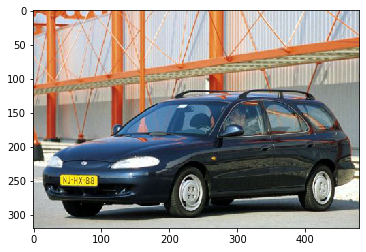

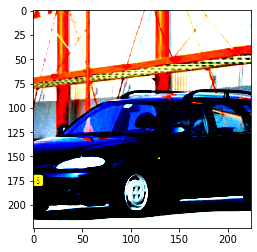

In [25]:
#画像前処理の動作を確認

#１　画像を読み込み
image_file_path = '67227983_ce131cca2a.jpg'
img = Image.open(image_file_path)

#2 元画像を表示
plt.imshow(img)
plt.show()

#3　画像の前処理と処理済みの画像の表示
resize = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = BaseTransform(resize, mean, std)
img_transformed = transform(img)

#（色、高さ、幅）を（高さ、幅、色）に変換し、０-１に値を制限して表示
img_transformed = img_transformed.numpy().transpose((1,2,0))
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()

In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [27]:
# ブラウザでフォルダを表示するとURLのfolders以降がフォルダのIDになっている
# https://drive.google.com/drive/folders/<ID>
dir_id = "1VNyV_SwwcjBcsjLKgLTpYWAL0fAQRf6N"

# フォルダ内にあるファイル名とファイルIDを表示する
file_list = drive.ListFile({'q': "'%s' in parents and trashed=false" % dir_id}).GetList()
for f in file_list:
  print("name: " + f["title"] + ", id: " + f["id"])

name: imagenet_class_index.json, id: 1OWEZ3MQAkaJny_iVGhgHSbQ1-FVjgt00


In [28]:
# 上記の方法で調べたファイルのID
file_id = "1OWEZ3MQAkaJny_iVGhgHSbQ1-FVjgt00"
drive_file = drive.CreateFile({'id': file_id})

# ファイルの取得
drive_file.GetContentFile("imagenet_class_index.json")

with open("imagenet_class_index.json", "r") as f:
  file_string = f.read()

file_string

'{"0": ["n01440764", "tench"], "1": ["n01443537", "goldfish"], "2": ["n01484850", "great_white_shark"], "3": ["n01491361", "tiger_shark"], "4": ["n01494475", "hammerhead"], "5": ["n01496331", "electric_ray"], "6": ["n01498041", "stingray"], "7": ["n01514668", "cock"], "8": ["n01514859", "hen"], "9": ["n01518878", "ostrich"], "10": ["n01530575", "brambling"], "11": ["n01531178", "goldfinch"], "12": ["n01532829", "house_finch"], "13": ["n01534433", "junco"], "14": ["n01537544", "indigo_bunting"], "15": ["n01558993", "robin"], "16": ["n01560419", "bulbul"], "17": ["n01580077", "jay"], "18": ["n01582220", "magpie"], "19": ["n01592084", "chickadee"], "20": ["n01601694", "water_ouzel"], "21": ["n01608432", "kite"], "22": ["n01614925", "bald_eagle"], "23": ["n01616318", "vulture"], "24": ["n01622779", "great_grey_owl"], "25": ["n01629819", "European_fire_salamander"], "26": ["n01630670", "common_newt"], "27": ["n01631663", "eft"], "28": ["n01632458", "spotted_salamander"], "29": ["n01632777",

In [29]:
#ILSVRCのラベル情報をロード
ILSVRC_class_index = json.load(open('imagenet_class_index.json','r'))
ILSVRC_class_index

{'0': ['n01440764', 'tench'],
 '1': ['n01443537', 'goldfish'],
 '2': ['n01484850', 'great_white_shark'],
 '3': ['n01491361', 'tiger_shark'],
 '4': ['n01494475', 'hammerhead'],
 '5': ['n01496331', 'electric_ray'],
 '6': ['n01498041', 'stingray'],
 '7': ['n01514668', 'cock'],
 '8': ['n01514859', 'hen'],
 '9': ['n01518878', 'ostrich'],
 '10': ['n01530575', 'brambling'],
 '11': ['n01531178', 'goldfinch'],
 '12': ['n01532829', 'house_finch'],
 '13': ['n01534433', 'junco'],
 '14': ['n01537544', 'indigo_bunting'],
 '15': ['n01558993', 'robin'],
 '16': ['n01560419', 'bulbul'],
 '17': ['n01580077', 'jay'],
 '18': ['n01582220', 'magpie'],
 '19': ['n01592084', 'chickadee'],
 '20': ['n01601694', 'water_ouzel'],
 '21': ['n01608432', 'kite'],
 '22': ['n01614925', 'bald_eagle'],
 '23': ['n01616318', 'vulture'],
 '24': ['n01622779', 'great_grey_owl'],
 '25': ['n01629819', 'European_fire_salamander'],
 '26': ['n01630670', 'common_newt'],
 '27': ['n01631663', 'eft'],
 '28': ['n01632458', 'spotted_salama

In [0]:
#出力結果からラベルを予測する後処理クラス
class ILSVRCPredictor():

  def __init__(self, class_index):
    self.class_index = class_index
  
  def predict_max(self, out):
    maxid = np.argmax(out.detach().numpy())
    predicted_label_name = self.class_index[str(maxid)][1]

    return predicted_label_name

In [31]:
#ILSVRCのラベル情報をロード
ILSVRC_class_index = json.load(open('imagenet_class_index.json','r'))

#ILSVRCPredictorのインスタンス生成
predictor = ILSVRCPredictor(ILSVRC_class_index)

#入力画像読み込み
image_file_path = '67227983_ce131cca2a.jpg'
img = Image.open(image_file_path)

#前処理のあと、バッチサイズの次元を追加する
transform = BaseTransform(resize, mean, std)
img_transformed = transform(img)
inputs = img_transformed.unsqueeze_(0)

#モデルに入力し、モデル出力をラベルに変換
out = net(inputs)
result = predictor.predict_max(out)

#予測の出力
print("入力画像の予測結果:", result)

入力画像の予測結果: beach_wagon
